In [1]:
import numpy as np
import emcee   #Install following https://emcee.readthedocs.io/en/stable/user/install/
import corner   #Install following https://emcee.readthedocs.io/en/stable/user/install/
import matplotlib.pyplot as plt

En este notebook veremos un par de ejemplos sencillos del uso de la libreria emcee para realizar inferencia bayesiana. 

      1.- Recta. Sigue muy de cerca el ejemplo en https://emcee.readthedocs.io/en/stable/tutorials/line/ excepto la parte de generar los datos.
      
      2.- COVID. Basado en https://arxiv.org/abs/2010.03097

## 1. Ejemplo recta. 

In [2]:
# Cargamos y graficamos los datos

Text(0, 0.5, 'y')

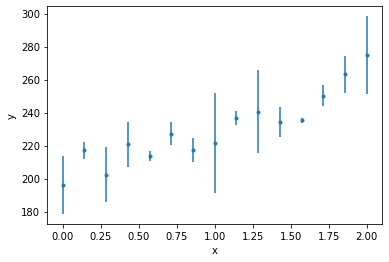

In [3]:
data_test=np.load("/Users/almagonzalez/Documents/cursos/DataAnalysis/DCIDA2020II/data/test_line.npy")
x,y,yerr=data_test
plt.errorbar(x,y,yerr,fmt='.')
plt.xlabel('x')
plt.ylabel('y')

In [4]:
yerr

array([17.68158841, -5.03133689, 16.58577924, 13.74440762,  2.87670665,
        6.82112915,  7.36724007, 30.33018382,  4.2901266 , 25.20427512,
       -9.21174822, -1.65378113, -6.43187287, 11.2999903 , 23.58489527])

De acuerdo con la gráfica arriba efectivamente un modelo de una recta, de la forma 

$y=m*x+b$

parece lo mas factible,
y debemos encontrar los valores de pendiente (m) y ordenada al origen (b). 

Basado en la gráfica podemos ver que los siguientes priors planos podrían ser usados: 

$100<b<300$

$0<m<100$

In [5]:
#definimos aquí todas las funciones a usar, i.e. modelo, posterior, likelihood, etc...

In [6]:
def linea(x,m,b):
    return m*x+b

In [7]:
def lnprior_(theta):
    m,b=theta
    if 0<m<100 and 100<b<300:
        return 0   #prior=1/(min-max)
    return -np.inf 

def lnlike_(theta,x,y,yerr):  #Gaussiano
    m,b=theta
    sigma2=yerr**2
    model=linea(x,m,b)
    llike=-0.5*np.sum((y-model)**2/sigma2)
    return llike
    
def lnpost_(theta,x,y,yerr):
    lnprior=lnprior_(theta)
    if not np.isfinite(lnprior):
        return -np.inf
    lnlike=lnlike_(theta,x,y,yerr)
    lnpost=lnlike+lnprior
    return lnpost

In [8]:
pos_ini=[50,200]

nwalkers, ndim = 32,2
chain_len=5000
pos = pos_ini+ 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost_,args=(data_test[0],data_test[1],data_test[2]))
sampler.run_mcmc(pos,chain_len, progress=True);

100%|██████████| 5000/5000 [00:13<00:00, 380.35it/s]


In [9]:
sampler

In [26]:
sampler.get_chain?

Signature: sampler.get_chain(**kwargs)
Docstring:
Get the stored chain of MCMC samples

Args:
    flat (Optional[bool]): Flatten the chain across the ensemble.
        (default: ``False``)
    thin (Optional[int]): Take only every ``thin`` steps from the
        chain. (default: ``1``)
    discard (Optional[int]): Discard the first ``discard`` steps in
        the chain as burn-in. (default: ``0``)

Returns:
    array[..., nwalkers, ndim]: The MCMC samples.
File:      ~/miniconda3.8/envs/DA2020II/lib/python3.7/site-packages/emcee/ensemble.py
Type:      method


In [18]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print(flat_samples.shape)

(156800, 2)


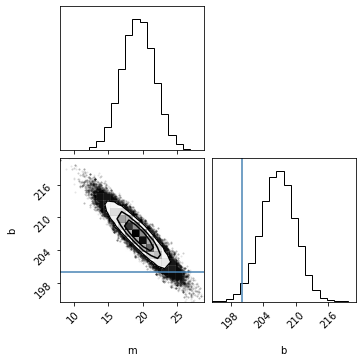

In [19]:
import corner
m_true,b_true=30,200
fig = corner.corner(
    flat_samples, labels=['m','b'], truths=[m_true, b_true]);

In [20]:
#Note that the recovered values are not corresponding the truth values, and this is because the errors in our fake data are not to be trusted and we are not doing anything special to model them... 
#One way to improve this would be to try to add free parameters to the variaance... 

#The next excersise is to implement the use of emcee for your own code routines...

In [21]:
corner.corner?

Signature:
corner.corner(
    xs,
    bins=20,
    range=None,
    weights=None,
    color='k',
    hist_bin_factor=1,
    smooth=None,
    smooth1d=None,
    labels=None,
    label_kwargs=None,
    titles=None,
    show_titles=False,
    title_fmt='.2f',
    title_kwargs=None,
    truths=None,
    truth_color='#4682b4',
    scale_hist=False,
    quantiles=None,
    verbose=False,
    fig=None,
    max_n_ticks=5,
    top_ticks=False,
    use_math_text=False,
    reverse=False,
    labelpad=0.0,
    hist_kwargs=None,
    **hist2d_kwargs,
)
Docstring:
Make a *sick* corner plot showing the projections of a data set in a
multi-dimensional space. kwargs are passed to hist2d() or used for
`matplotlib` styling.

Parameters
----------
xs : array_like[nsamples, ndim]
    The samples. This should be a 1- or 2-dimensional array. For a 1-D
    array this results in a simple histogram. For a 2-D array, the zeroth
    axis is the list of samples and the next axis are the dimensions of
    the space.

In [25]:
from IPython.display import display, Math
labels=["a","b"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

IndexError: list index out of range